In [1]:
import numpy as np
import pandas as pd

# Run implementation.py
%run implementation.py

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
class KArmedTestbed:
    def __init__(self, k, means=None, variances=None):
        self.k = k
        if means: self.means = means
        else: self.means = np.zeros(k)
        if variances: self.variances = means
        else: self.variances = np.ones(k)
            
    def walk(self, mean, variance):
        self.means = self.means + np.random.normal(mean, variance, self.k)
        
    def display(self,):
        data = np.array([np.random.normal(mean, variance, 1000) for (mean, variance) in zip(self.means, self.variances)])
        fig, ax = plt.subplots()
        sns.violinplot(data=data.T, inner=None, linewidth=0, ax=ax)
        for idx, mean in enumerate(self.means):
            ax.plot([idx-0.4,idx+0.4], [mean,mean], color="k")
        ax.set_xlabel("Action")
        ax.set_ylabel("Reward Distribution")
        return fig

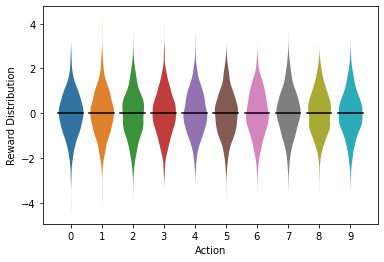

In [3]:
actions = 10
ten_armed_testbed = KArmedTestbed(actions)
ten_armed_testbed.display()
print()

In [46]:
class EGreedy:
    def __init__(self, actions, alpha=None, epsilon=0.1, initial_values=0, action_selection="e-greedy"):
        self.actions = actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.observations = {}
        if initial_values != None:
            # realistic or optimistic intitial values
            for action in self.actions:
                self.observations[action] = initial_values
        else:
            # random initial values
            for action in self.actions:
                self.observations[action] = np.random.rand()
                
        self.action_selection = action_selection
        if self.action_selection == "ucb":
            self.action_selections = {}
            for action in self.actions:
                self.action_selections[action] = 0

        # current step
        self.current_step = 1
            
    def act_observe_update(self, k_armed_testbed, walk_mean=0, walk_variance=0.01):
        # 1) Act
        if self.action_selection == "e-greedy":
            random_number = np.random.rand()
            if random_number > 1 - self.epsilon:
                # explore
                action = np.random.choice(self.actions)
            else:
                # exploit
                max_value_keys = [key for key in self.observations.keys() \
                                  if self.observations[key] == max(self.observations.values())]
                action = np.random.choice(max_value_keys)
        elif self.action_selection == "ucb":
            # for now set c = 2.0
            optimal_potentials = np.array(list(self.observations.values()))+ \
                               (2.0*np.sqrt(np.log(self.current_step)/np.array(list(self.action_selections.values()))))
            # first check for nans
            max_value_keys = [action for action, optimal_potential in zip(self.actions, optimal_potentials) \
                              if np.isnan(optimal_potential)]
            # if no optimal_potential == nan
            if len(max_value_keys) == 0:
                max_value_keys = [action for action, optimal_potential in zip(self.actions, optimal_potentials) \
                              if optimal_potential == max(optimal_potentials)]
            action = np.random.choice(max_value_keys)
            self.action_selections[action] = self.action_selections[action] + 1
        # 2) Observe    
        mean = k_armed_testbed.means[action]
        variance = k_armed_testbed.variances[action]
        reward = np.random.normal(mean, variance)
        # 3) Update
        if self.alpha == None:
            # use 1/n instead of alpha
            self.observations[action] = self.observations[action] + \
            ((1/self.current_step)*(reward-self.observations[action]))
        else:
            # use alpha instead of 1/n
            self.observations[action] = self.observations[action] + \
            ((self.alpha)*(reward-self.observations[action]))

        self.current_step = self.current_step + 1
        k_armed_testbed.walk(walk_mean, walk_variance)
        
        return action, reward
        
    def print_observations(self,):
        print(self.observations)

In [47]:
results = {
    "sample_averages": {},
    "constant_step_size": {}
}
for run in range(200):
    ten_armed_testbed = KArmedTestbed(actions)
    sample_averages = EGreedy(list(range(actions)))
    results["sample_averages"]["run-{}".format(run)] = {"rewards": [], "optimal_action": []}
    for idx in range(1,10000):
        action, reward = sample_averages.act_observe_update(ten_armed_testbed)
        results["sample_averages"]["run-{}".format(run)]["rewards"].append(reward)
        results["sample_averages"]["run-{}".format(run)]["optimal_action"]\
        .append(int(action == np.argmax(ten_armed_testbed.means)))
    ten_armed_testbed = KArmedTestbed(actions)
    constant_step_size = EGreedy(list(range(actions)), 0.1)
    results["constant_step_size"]["run-{}".format(run)] = {"rewards": [], "optimal_action": []}
    for idx in range(1,10000):
        action, reward = constant_step_size.act_observe_update(ten_armed_testbed)
        results["constant_step_size"]["run-{}".format(run)]["rewards"].append(reward)
        results["constant_step_size"]["run-{}".format(run)]["optimal_action"]\
        .append(int(action == np.argmax(ten_armed_testbed.means)))

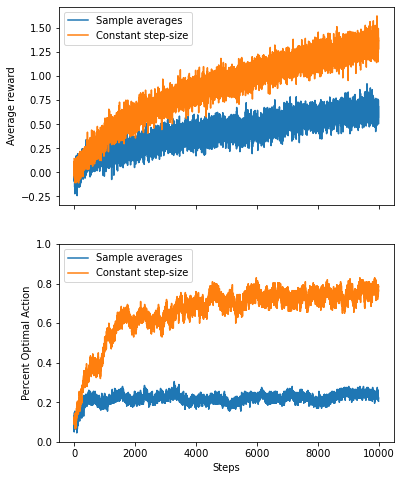

In [48]:
fig, ax = plt.subplots(2,1, figsize=(6,8), sharex=True)
sample_averages_mean_rewards = np.mean([results["sample_averages"][key]["rewards"] for key in results["sample_averages"]], axis=0)
constant_step_size_mean_rewards = np.mean([results["constant_step_size"][key]["rewards"] for key in results["constant_step_size"]], axis=0)
ax[0].plot(sample_averages_mean_rewards, label="Sample averages")
ax[0].plot(constant_step_size_mean_rewards, label="Constant step-size")
ax[0].set_ylabel("Average reward")
ax[0].legend()
#
sample_averages_mean_rewards = np.mean([results["sample_averages"][key]["optimal_action"] for key in results["sample_averages"]], axis=0)
constant_step_size_mean_rewards = np.mean([results["constant_step_size"][key]["optimal_action"] for key in results["constant_step_size"]], axis=0)
ax[1].plot(sample_averages_mean_rewards, label="Sample averages")
ax[1].plot(constant_step_size_mean_rewards, label="Constant step-size")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Percent Optimal Action")
ax[1].set_ylim([0,1])
ax[1].legend()
plt.show()

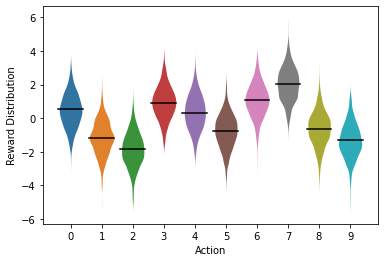

In [49]:
ten_armed_testbed.display()
print()

In [50]:
results = {
    "e_greedy": {},
    "ucb": {}
}
for run in range(200):
    ten_armed_testbed = KArmedTestbed(actions)
    sample_averages = EGreedy(list(range(actions)), alpha=0.1)
    results["e_greedy"]["run-{}".format(run)] = {"rewards": [], "optimal_action": []}
    for idx in range(1,10000):
        action, reward = sample_averages.act_observe_update(ten_armed_testbed)
        results["e_greedy"]["run-{}".format(run)]["rewards"].append(reward)
        results["e_greedy"]["run-{}".format(run)]["optimal_action"]\
        .append(int(action == np.argmax(ten_armed_testbed.means)))
    ten_armed_testbed = KArmedTestbed(actions)
    constant_step_size = EGreedy(list(range(actions)), alpha=0.1, action_selection="ucb")
    results["ucb"]["run-{}".format(run)] = {"rewards": [], "optimal_action": []}
    for idx in range(1,10000):
        action, reward = constant_step_size.act_observe_update(ten_armed_testbed)
        results["ucb"]["run-{}".format(run)]["rewards"].append(reward)
        results["ucb"]["run-{}".format(run)]["optimal_action"]\
        .append(int(action == np.argmax(ten_armed_testbed.means)))

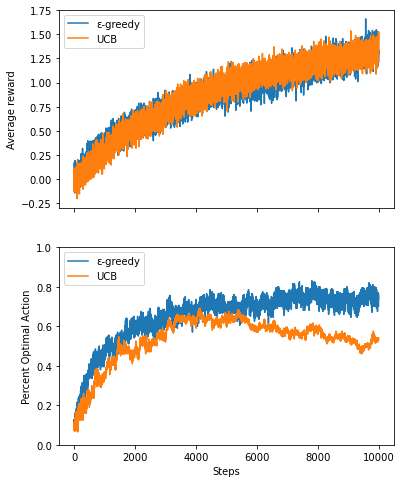

In [51]:
fig, ax = plt.subplots(2,1, figsize=(6,8), sharex=True)
sample_averages_mean_rewards = np.mean([results["e_greedy"][key]["rewards"] for key in results["e_greedy"]], axis=0)
constant_step_size_mean_rewards = np.mean([results["ucb"][key]["rewards"] for key in results["ucb"]], axis=0)
ax[0].plot(sample_averages_mean_rewards, label="\u03B5-greedy")
ax[0].plot(constant_step_size_mean_rewards, label="UCB")
ax[0].set_ylabel("Average reward")
ax[0].legend()
# alpha unicode \u03B1
sample_averages_mean_rewards = np.mean([results["e_greedy"][key]["optimal_action"] for key in results["e_greedy"]], axis=0)
constant_step_size_mean_rewards = np.mean([results["ucb"][key]["optimal_action"] for key in results["ucb"]], axis=0)
ax[1].plot(sample_averages_mean_rewards, label="\u03B5-greedy")
ax[1].plot(constant_step_size_mean_rewards, label="UCB")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Percent Optimal Action")
ax[1].set_ylim([0,1])
ax[1].legend()
plt.show()